In [3]:
import spacy
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple, Dict
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

from torchtext.data.metrics import bleu_score

### constants ###

PARENT_DIR = '/content/gdrive/MyDrive/CS287_Research_Project/Jennas_Code/'
n_extra_tokens = 4
UNK_IDX = 0 
PADDING_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3 

# !pip install spacy==3.1.1

# import spacy.cli
# spacy.cli.download("de_core_news_lg")
# spacy.cli.download("en_core_web_lg")

# source_nlp = spacy.load("de_core_news_lg")
# target_nlp = spacy.load("en_core_web_lg")

In [4]:
import torch
from google.colab import drive
drive.mount('/content/gdrive') # for google colab. adjust accordingly

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import sys  
sys.path.insert(0, PARENT_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
True
Tesla P100-PCIE-16GB
cuda


In [5]:
# from EncoderLSTM import *
# from DecoderLSTM import *
# from Seq2Seq import *
# from train import *

# from load_data import *

# mt_train_ds, mt_val_ds, mt_test_ds, mt_train_dl, mt_val_dl, mt_test_dl = build_dataloaders(batch_size = 32)

# with open(PARENT_DIR+'/data/dataloaders10perc_batchsize32/mt_train_ds.pickle', 'wb') as handle:
#     pickle.dump(mt_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PARENT_DIR+'/data/dataloaders10perc_batchsize32/mt_test_ds.pickle', 'wb') as handle:
#     pickle.dump(mt_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PARENT_DIR+'/data/dataloaders10perc_batchsize32/mt_val_ds.pickle', 'wb') as handle:
#     pickle.dump(mt_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PARENT_DIR+'/data/dataloaders10perc_batchsize32/mt_train_dl.pickle', 'wb') as handle:
#     pickle.dump(mt_train_dl, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PARENT_DIR+'/data/dataloaders10perc_batchsize32/mt_test_dl.pickle', 'wb') as handle:
#     pickle.dump(mt_test_dl, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(PARENT_DIR+'/data/dataloaders10perc_batchsize32/mt_val_dl.pickle', 'wb') as handle:
#     pickle.dump(mt_val_dl, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
class Autoreg_LM(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, padding_idx: int, device):
        super().__init__()
        
        self.input_size = input_size        # vocab size
        self.hidden_size = hidden_size
        self.padding_idx = padding_idx
        self.embedding_size = hidden_size   # embedding size was not specified so I made it same as hidden size
        
        self.embedding = torch.nn.Embedding(
            num_embeddings = self.input_size,
            embedding_dim = self.embedding_size,
            padding_idx = PADDING_IDX
        )

        self.lstm = torch.nn.LSTM(
            input_size = self.embedding_size,
            hidden_size = self.embedding_size,
            batch_first = True,
            num_layers = 2,
            bidirectional = True
        )

        self.linear = torch.nn.Linear(
            self.embedding_size*8,
            self.input_size # value for each word
        )

        self.logsoft = nn.LogSoftmax(dim = 1)

    def split_one_seq(self, seq):
      contexts = []
      targets = []
      for i in range(1,len(seq)):
        zeros = torch.Tensor([0]*(int(len(seq) - i))).to(device)
        contexts.append(torch.cat([seq[:i], zeros]))
        targets.append(int(seq[i]))

      contexts = torch.stack(contexts)
      return contexts, targets

    def split_seqs(self, input_seqs):
      contexts = []
      targets = []
      for seq in input_seqs:
        this_context, this_target = self.split_one_seq(seq)
        contexts.append(this_context)
        targets.append(this_target)
      contexts = torch.stack(contexts)
      targets = torch.Tensor(targets)
      return contexts, targets

    def flatten(self, contexts, targets, padding_idx):
      contexts_flat = torch.flatten(contexts, end_dim = 1)
      targets_flat = torch.flatten(targets)

      filter = (targets_flat != padding_idx)

      return contexts_flat[filter,:].long(), targets_flat[filter]

    def forward(self, input_seqs) -> Tuple[torch.tensor, torch.tensor]: 
        context, target = self.split_seqs(input_seqs)
        context_flat, target_flat = self.flatten(context, target, PADDING_IDX)
        
        lengths = torch.Tensor([int(sum(x != self.padding_idx)) for x in context_flat])

        embedded = self.embedding(context_flat.long())

        packed_padded_seqs = torch.nn.utils.rnn.pack_padded_sequence(
          embedded, batch_first = True, lengths = lengths,
          enforce_sorted=False
        )

        lstm_out, (h, c) = self.lstm(packed_padded_seqs)

        # concatenate hidden and cell states of both directions and both layers
        meaning = torch.cat([h[0], h[1], h[2], h[3], c[0], c[1], c[2], c[3]], dim = 1)

        linear_out = self.linear(meaning)

        return linear_out, target_flat.to(device)

    def generate(self, input_seqs):
      with torch.no_grad():
        lengths = torch.Tensor([int(sum(x != self.padding_idx)) for x in input_seqs])

        embedded = self.embedding(input_seqs.long())

        packed_padded_seqs = torch.nn.utils.rnn.pack_padded_sequence(
          embedded, batch_first = True, lengths = lengths,
          enforce_sorted=False
        )

        lstm_out, (h, c) = self.lstm(packed_padded_seqs)

        # concatenate hidden and cell states of both directions and both layers
        meaning = torch.cat([h[0], h[1], h[2], h[3], c[0], c[1], c[2], c[3]], dim = 1)

        linear_out = self.linear(meaning)
        pred = self.logsoft(linear_out)
        return pred


In [7]:
from EncoderLSTM import *
from DecoderLSTM import *
from Seq2Seq import *
from train import *

In [8]:
def compute_test_loss(model, test_dl, loss_fn):
  all_preds, all_targs = [], []
  for i, (input_seqs, output_seqs, input_pos, output_pos) in enumerate(test_dl):
      preds, targs = model(input_seqs.to(device))
      all_preds.append(preds)
      all_targs.append(targs)
  preds = torch.cat(all_preds, dim=0)
  targs = torch.cat(all_targs, dim=0)
  return loss_fn(preds, targs.long())

# LM on small dataset, trained better

In [14]:
from load_data import load_pickled_dataloaders
# 10% sample batch size = 32
mt_train_ds, mt_val_ds, mt_test_ds, mt_train_dl, mt_val_dl, mt_test_dl = load_pickled_dataloaders(batch1 = True)
accum_iter = 32
epochs = 20
hidden_size = 64

# full data
# mt_train_ds, mt_test_ds, mt_train_dl, mt_test_dl = load_pickled_dataloaders(small = False)

In [15]:
%%time

from torch.optim import Adam
from torch.nn import CrossEntropyLoss

lm = Autoreg_LM(
    input_size = mt_train_ds.source_vocab_size,
    hidden_size = hidden_size,
    padding_idx = PADDING_IDX,
    device = device
).to(device)

optimizer = Adam(params = lm.parameters(), lr = 0.0001)
loss_fn = CrossEntropyLoss()

train_losses = []
val_losses = []
model_paths = []
model_path = PARENT_DIR+'/jennas_models2/'

# training looop
for epoch in range(epochs):
    running_loss = 0
    count = 0
    for batch_idx, batch in enumerate(tqdm(mt_train_dl, leave = False)):

        preds, targets = lm(batch[0].to(device))
        loss = loss_fn(preds, targets.long())
                
        running_loss += loss.item()
        count += 1

        loss = loss/accum_iter
        loss.backward()

        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(mt_train_dl)):
            optimizer.step()
            optimizer.zero_grad()

    val_loss = compute_test_loss(lm, mt_val_dl, loss_fn).item()
                
    train_losses.append(running_loss/count)
    val_losses.append(val_loss)
    model_paths.append(model_path+str(epoch))

    torch.save(lm, model_path + 'epoch' + str(epoch))

    print('epoch', epoch+1, ': training loss :', round(running_loss/count,4),
          ': validation loss :', round(val_loss, 4))

epoch 1 : training loss : 6.0843 : validation loss : 5.7216


epoch 2 : training loss : 5.6055 : validation loss : 5.6795


epoch 3 : training loss : 5.5461 : validation loss : 5.6517


epoch 4 : training loss : 5.486 : validation loss : 5.6052


epoch 5 : training loss : 5.4164 : validation loss : 5.5584


epoch 6 : training loss : 5.3537 : validation loss : 5.5379


epoch 7 : training loss : 5.2919 : validation loss : 5.5097


epoch 8 : training loss : 5.2345 : validation loss : 5.4747


epoch 9 : training loss : 5.1795 : validation loss : 5.4491


epoch 10 : training loss : 5.1252 : validation loss : 5.4277


epoch 11 : training loss : 5.0724 : validation loss : 5.3935


epoch 12 : training loss : 5.0227 : validation loss : 5.3679


epoch 13 : training loss : 4.9755 : validation loss : 5.3544


epoch 14 : training loss : 4.9308 : validation loss : 5.3315


epoch 15 : training loss : 4.8875 : validation loss : 5.3237


epoch 16 : training loss : 4.8468 : validation loss : 5.3128


epoch 17 : training loss : 4.8071 : validation loss : 5.3032


epoch 18 : training loss : 4.7683 : validation loss : 5.3051


epoch 19 : training loss : 4.731 : validation loss : 5.2981


epoch 20 : training loss : 4.6953 : validation loss : 5.2855
CPU times: user 1h 36min 35s, sys: 1min 53s, total: 1h 38min 28s
Wall time: 1h 39min 9s


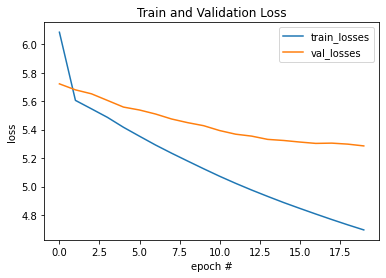

In [19]:
pd.DataFrame({
    'train_losses': train_losses,
    'val_losses': val_losses
}).plot(xlabel='epoch #', ylabel='loss', title='Train and Validation Loss')

In [20]:
for epoch in range(epochs, epochs*2):
    running_loss = 0
    count = 0
    for batch_idx, batch in enumerate(tqdm(mt_train_dl, leave = False)):

        preds, targets = lm(batch[0].to(device))
        loss = loss_fn(preds, targets.long())
                
        running_loss += loss.item()
        count += 1

        loss = loss/accum_iter
        loss.backward()

        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(mt_train_dl)):
            optimizer.step()
            optimizer.zero_grad()

    val_loss = compute_test_loss(lm, mt_val_dl, loss_fn).item()
                
    train_losses.append(running_loss/count)
    val_losses.append(val_loss)
    model_paths.append(model_path+str(epoch))

    torch.save(lm, model_path + 'epoch' + str(epoch))

    print('epoch', epoch+1, ': training loss :', round(running_loss/count,4),
          ': validation loss :', round(val_loss, 4))

epoch 21 : training loss : 4.6586 : validation loss : 5.2969


epoch 22 : training loss : 4.6238 : validation loss : 5.2948


epoch 23 : training loss : 4.5906 : validation loss : 5.2873


epoch 24 : training loss : 4.5561 : validation loss : 5.295


KeyboardInterrupt: ignored

Note: I manually interrupted training because I could see the validation loss leveling out

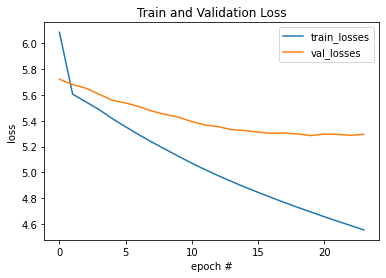

In [21]:
pd.DataFrame({
    'train_losses': train_losses,
    'val_losses': val_losses
}).plot(xlabel='epoch #', ylabel='loss', title='Train and Validation Loss')

In [51]:
which = val_losses.index(min(val_losses))
print(which)
lm_best = torch.load(model_path + 'epoch' + str(which))

19


In [52]:
lm_best.generate(torch.Tensor([[1,2,3]]).to(device))

torch.Size([4, 2, 64])

Note: I originally messed up the generate function and didn't want to wait another 2 hours for this to train again. My hacky workaround was to create a bound method :/

In [53]:
def generate(self, input_seqs):
  with torch.no_grad():
    lengths = torch.Tensor([int(sum(x != self.padding_idx)) for x in input_seqs])

    embedded = self.embedding(input_seqs.long())

    packed_padded_seqs = torch.nn.utils.rnn.pack_padded_sequence(
      embedded, batch_first = True, lengths = lengths,
      enforce_sorted=False
    )

    lstm_out, (h, c) = self.lstm(packed_padded_seqs)

    # concatenate hidden and cell states of both directions and both layers
    meaning = torch.cat([h[0], h[1], h[2], h[3], c[0], c[1], c[2], c[3]], dim = 1)

    linear_out = self.linear(meaning)
    pred = self.logsoft(linear_out)
    return pred

lm_best.generate = generate.__get__(lm_best)

In [55]:
lm_best.generate(torch.Tensor([[1,2,3]]).to(device))

tensor([[ -5.7043,  -9.4225,  -9.7102,  ...,  -7.6038, -10.0476, -10.0659]],
       device='cuda:0')

In [54]:
torch.save(lm_best, PARENT_DIR+'jennas_lm')

In [56]:
test_save = torch.load(PARENT_DIR+'jennas_lm')
test_save.generate(torch.Tensor([[1,2,3]]).to(device))

torch.Size([4, 2, 64])

In [57]:
test_save.generate = generate.__get__(test_save)
test_save.generate(torch.Tensor([[1,2,3]]).to(device))

tensor([[ -5.7043,  -9.4225,  -9.7102,  ...,  -7.6038, -10.0476, -10.0659]],
       device='cuda:0')

Bound method does not save with torch.save() & torch.load(). I created a python script to load the model and re-bind the correct generate function.

# Code to load with Python script

In [ ]:
import sys  
sys.path.insert(0, PARENT_DIR)

import load_lm
test_script_save = load_lm.load_lm()
test_script_save.generate(torch.Tensor([[1,2,3]]).to(device))